In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
plt.style.use("ggplot")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/08_data_pre_processing_for_openface/ekman/all_videos_emotion_merged_without_success0.csv")
df.head()

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,...,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,filename,emotion,videoname
0,1,0,0.00,0.98,1,0.217484,0.400964,-0.889904,0.050022,0.410571,-0.910455,0.148,0.423,688.7,689.9,694.0,698.6,700.9,700.0,695.6,691.1,681.6,684.7,688.8,693.5,698.2,701.8,704.6,702.1,698.2,693.6,689.1,684.9,693.1,695.0,696.8,697.3,696.3,694.3,692.6,...,-0.107,0.160,0.42,0.0,0.0,0.0,0.08,2.46,0.69,0.96,0.86,0.17,1.33,0.0,0.37,0.0,1.53,1.38,0.98,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,anger,video01
1,2,0,0.04,0.98,1,0.223496,0.397311,-0.890052,0.019622,0.406862,-0.913279,0.134,0.419,687.7,689.0,693.2,697.8,700.2,699.1,694.7,690.1,680.3,683.5,687.7,692.6,697.4,701.1,703.7,701.2,697.3,692.7,688.0,683.7,692.1,694.1,695.9,696.5,695.5,693.5,691.7,...,-0.041,0.100,0.46,0.0,0.0,0.0,0.17,2.79,0.65,1.04,1.01,0.51,1.47,0.0,0.03,0.0,1.47,1.27,0.78,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,anger,video01
2,3,0,0.08,0.98,1,0.220156,0.372378,-0.901591,0.014346,0.395123,-0.918516,0.128,0.399,686.9,688.3,692.5,697.1,699.3,698.2,693.7,689.1,679.7,682.8,686.9,691.8,696.6,700.3,703.0,700.3,696.4,691.7,687.2,683.0,691.3,693.2,695.1,695.7,694.7,692.7,690.9,...,-0.044,0.102,0.39,0.0,0.0,0.0,0.15,2.77,0.57,1.06,0.88,0.82,1.48,0.0,0.08,0.0,1.40,1.15,0.70,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,anger,video01
3,4,0,0.12,0.98,1,0.232741,0.351699,-0.906719,0.029666,0.370821,-0.928231,0.142,0.375,684.7,686.3,690.5,695.0,697.1,695.8,691.3,686.8,677.4,680.6,684.8,689.6,694.4,698.0,700.6,697.9,694.0,689.5,684.9,680.7,689.0,690.9,692.8,693.4,692.5,690.6,688.8,...,-0.029,0.101,0.37,0.0,0.0,0.0,0.22,2.50,0.60,0.79,1.01,1.16,1.38,0.0,0.00,0.0,1.31,0.98,0.65,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,anger,video01
4,5,0,0.16,0.98,1,0.220415,0.332130,-0.917119,0.030642,0.365490,-0.930311,0.135,0.361,682.3,683.9,688.2,692.6,694.6,693.3,688.7,684.3,675.2,678.5,682.7,687.5,692.1,695.7,698.2,695.6,691.7,687.1,682.6,678.4,686.5,688.4,690.3,691.0,690.1,688.2,686.3,...,-0.037,0.123,0.38,0.0,0.0,0.0,0.29,2.99,0.57,0.86,0.67,0.59,1.40,0.0,0.00,0.0,1.00,0.88,0.89,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,output_video107.csv,anger,video01


In [ ]:
# Encode Output Class
class2idx = {
    'anger':0,
    'joy':1,
    'neutral':2,
    'surprise':3,
    'disgust':4,
    'sadness':5,
    'fear':6
}
idx2class = {v: k for k, v in class2idx.items()}
df["emotion"].replace(class2idx, inplace=True)

TypeError: ignored

In [ ]:
X = df.drop(["frame","emotion","videoname","filename"], axis=1)
y = df["emotion"]

In [ ]:
X.head()

,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,eye_lmk_x_27,...,p_29,p_30,p_31,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,0,0.00,0.98,1,0.217484,0.400964,-0.889904,0.050022,0.410571,-0.910455,0.148,0.423,688.7,689.9,694.0,698.6,700.9,700.0,695.6,691.1,681.6,684.7,688.8,693.5,698.2,701.8,704.6,702.1,698.2,693.6,689.1,684.9,693.1,695.0,696.8,697.3,696.3,694.3,692.6,692.1,...,-0.195,0.369,-0.091,-0.107,0.160,0.42,0.0,0.0,0.0,0.08,2.46,0.69,0.96,0.86,0.17,1.33,0.0,0.37,0.0,1.53,1.38,0.98,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,0,0.04,0.98,1,0.223496,0.397311,-0.890052,0.019622,0.406862,-0.913279,0.134,0.419,687.7,689.0,693.2,697.8,700.2,699.1,694.7,690.1,680.3,683.5,687.7,692.6,697.4,701.1,703.7,701.2,697.3,692.7,688.0,683.7,692.1,694.1,695.9,696.5,695.5,693.5,691.7,691.1,...,-0.173,0.404,-0.102,-0.041,0.100,0.46,0.0,0.0,0.0,0.17,2.79,0.65,1.04,1.01,0.51,1.47,0.0,0.03,0.0,1.47,1.27,0.78,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2,0,0.08,0.98,1,0.220156,0.372378,-0.901591,0.014346,0.395123,-0.918516,0.128,0.399,686.9,688.3,692.5,697.1,699.3,698.2,693.7,689.1,679.7,682.8,686.9,691.8,696.6,700.3,703.0,700.3,696.4,691.7,687.2,683.0,691.3,693.2,695.1,695.7,694.7,692.7,690.9,690.3,...,-0.113,0.422,-0.119,-0.044,0.102,0.39,0.0,0.0,0.0,0.15,2.77,0.57,1.06,0.88,0.82,1.48,0.0,0.08,0.0,1.40,1.15,0.70,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,0,0.12,0.98,1,0.232741,0.351699,-0.906719,0.029666,0.370821,-0.928231,0.142,0.375,684.7,686.3,690.5,695.0,697.1,695.8,691.3,686.8,677.4,680.6,684.8,689.6,694.4,698.0,700.6,697.9,694.0,689.5,684.9,680.7,689.0,690.9,692.8,693.4,692.5,690.6,688.8,688.1,...,-0.101,0.409,-0.106,-0.029,0.101,0.37,0.0,0.0,0.0,0.22,2.50,0.60,0.79,1.01,1.16,1.38,0.0,0.00,0.0,1.31,0.98,0.65,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,0,0.16,0.98,1,0.220415,0.332130,-0.917119,0.030642,0.365490,-0.930311,0.135,0.361,682.3,683.9,688.2,692.6,694.6,693.3,688.7,684.3,675.2,678.5,682.7,687.5,692.1,695.7,698.2,695.6,691.7,687.1,682.6,678.4,686.5,688.4,690.3,691.0,690.1,688.2,686.3,685.6,...,-0.144,0.413,-0.120,-0.037,0.123,0.38,0.0,0.0,0.0,0.29,2.99,0.57,0.86,0.67,0.59,1.40,0.0,0.00,0.0,1.00,0.88,0.89,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [ ]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: emotion, dtype: int64

In [ ]:
del df

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
del X,y

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
target_df =pd.read_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/06_openface/ekman/video07/surprise/output_video25.csv")
target_df.head()

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,...,p_29,p_30,p_31,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.000,0.98,1,0.440247,0.317087,-0.840023,0.314565,0.321081,-0.893284,0.411,0.353,560.6,561.7,564.8,567.9,569.3,568.4,565.2,562.0,555.7,558.1,561.3,564.8,568.1,570.4,571.9,570.2,567.6,564.6,561.3,558.2,563.5,564.9,566.2,566.7,566.1,564.7,563.4,...,0.032,-0.067,-0.025,-0.022,0.017,0.49,0.0,0.80,0.34,0.00,0.00,0.69,0.00,0.00,0.00,0.96,0.0,0.43,0.0,0.49,0.56,0.00,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1,1,0.000,0.03,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,542.9,544.5,547.6,550.4,551.3,549.9,546.6,543.8,539.0,540.9,543.5,546.8,550.1,552.5,554.0,551.8,548.9,545.8,543.0,540.6,545.7,547.0,548.3,549.0,548.6,547.4,546.0,...,0.039,-0.013,0.027,0.010,-0.001,1.18,0.0,0.00,0.34,0.05,3.11,0.25,0.64,0.76,0.25,0.00,0.0,0.23,0.0,0.83,1.35,0.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,2,0,0.033,0.98,1,0.438633,0.320192,-0.839689,0.315952,0.322629,-0.892236,0.411,0.355,561.5,562.6,565.6,568.7,570.1,569.2,566.1,563.0,556.7,559.0,562.2,565.7,568.9,571.2,572.7,571.0,568.5,565.5,562.2,559.2,564.4,565.8,567.1,567.6,566.9,565.6,564.3,...,0.020,-0.110,-0.033,-0.023,0.030,0.35,0.0,0.73,0.26,0.00,0.00,0.73,0.00,0.00,0.00,1.04,0.0,0.48,0.0,0.48,0.41,0.07,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,2,1,0.033,0.03,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,540.8,542.5,546.0,549.2,550.2,548.6,544.9,541.8,536.1,538.4,541.5,545.2,548.8,551.3,553.0,550.6,547.5,544.1,540.9,538.0,543.8,545.2,546.7,547.5,547.1,545.7,544.2,...,0.031,-0.021,0.014,0.009,-0.007,0.49,0.0,0.00,0.00,0.24,2.41,0.39,0.20,0.25,0.17,0.00,0.0,0.00,0.0,0.24,0.95,0.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,3,0,0.067,0.98,1,0.433985,0.320351,-0.842041,0.311924,0.322256,-0.893787,0.406,0.355,562.4,563.5,566.5,569.7,571.1,570.2,567.0,563.8,557.6,559.9,563.1,566.6,569.8,572.2,573.7,572.0,569.4,566.4,563.1,560.0,565.3,566.7,568.0,568.5,567.9,566.5,565.2,...,0.022,-0.103,-0.026,-0.025,0.026,0.41,0.0,0.71,0.20,0.00,0.00,0.71,0.00,0.00,0.00,1.07,0.0,0.61,0.0,0.46,0.70,0.08,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
target_df["frame"]=target_df["frame"]-1
target_df.head()

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,...,p_29,p_30,p_31,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,0,0,0.000,0.98,1,0.440247,0.317087,-0.840023,0.314565,0.321081,-0.893284,0.411,0.353,560.6,561.7,564.8,567.9,569.3,568.4,565.2,562.0,555.7,558.1,561.3,564.8,568.1,570.4,571.9,570.2,567.6,564.6,561.3,558.2,563.5,564.9,566.2,566.7,566.1,564.7,563.4,...,0.032,-0.067,-0.025,-0.022,0.017,0.49,0.0,0.80,0.34,0.00,0.00,0.69,0.00,0.00,0.00,0.96,0.0,0.43,0.0,0.49,0.56,0.00,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,1,0.000,0.03,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,542.9,544.5,547.6,550.4,551.3,549.9,546.6,543.8,539.0,540.9,543.5,546.8,550.1,552.5,554.0,551.8,548.9,545.8,543.0,540.6,545.7,547.0,548.3,549.0,548.6,547.4,546.0,...,0.039,-0.013,0.027,0.010,-0.001,1.18,0.0,0.00,0.34,0.05,3.11,0.25,0.64,0.76,0.25,0.00,0.0,0.23,0.0,0.83,1.35,0.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,1,0,0.033,0.98,1,0.438633,0.320192,-0.839689,0.315952,0.322629,-0.892236,0.411,0.355,561.5,562.6,565.6,568.7,570.1,569.2,566.1,563.0,556.7,559.0,562.2,565.7,568.9,571.2,572.7,571.0,568.5,565.5,562.2,559.2,564.4,565.8,567.1,567.6,566.9,565.6,564.3,...,0.020,-0.110,-0.033,-0.023,0.030,0.35,0.0,0.73,0.26,0.00,0.00,0.73,0.00,0.00,0.00,1.04,0.0,0.48,0.0,0.48,0.41,0.07,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1,1,0.033,0.03,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,540.8,542.5,546.0,549.2,550.2,548.6,544.9,541.8,536.1,538.4,541.5,545.2,548.8,551.3,553.0,550.6,547.5,544.1,540.9,538.0,543.8,545.2,546.7,547.5,547.1,545.7,544.2,...,0.031,-0.021,0.014,0.009,-0.007,0.49,0.0,0.00,0.00,0.24,2.41,0.39,0.20,0.25,0.17,0.00,0.0,0.00,0.0,0.24,0.95,0.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,2,0,0.067,0.98,1,0.433985,0.320351,-0.842041,0.311924,0.322256,-0.893787,0.406,0.355,562.4,563.5,566.5,569.7,571.1,570.2,567.0,563.8,557.6,559.9,563.1,566.6,569.8,572.2,573.7,572.0,569.4,566.4,563.1,560.0,565.3,566.7,568.0,568.5,567.9,566.5,565.2,...,0.022,-0.103,-0.026,-0.025,0.026,0.41,0.0,0.71,0.20,0.00,0.00,0.71,0.00,0.00,0.00,1.07,0.0,0.61,0.0,0.46,0.70,0.08,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
X_target = target_df.drop(['frame'], axis=1)
X_target.head()

,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,eye_lmk_x_27,...,p_29,p_30,p_31,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,0,0.000,0.98,1,0.440247,0.317087,-0.840023,0.314565,0.321081,-0.893284,0.411,0.353,560.6,561.7,564.8,567.9,569.3,568.4,565.2,562.0,555.7,558.1,561.3,564.8,568.1,570.4,571.9,570.2,567.6,564.6,561.3,558.2,563.5,564.9,566.2,566.7,566.1,564.7,563.4,562.9,...,0.032,-0.067,-0.025,-0.022,0.017,0.49,0.0,0.80,0.34,0.00,0.00,0.69,0.00,0.00,0.00,0.96,0.0,0.43,0.0,0.49,0.56,0.00,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1,0.000,0.03,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,542.9,544.5,547.6,550.4,551.3,549.9,546.6,543.8,539.0,540.9,543.5,546.8,550.1,552.5,554.0,551.8,548.9,545.8,543.0,540.6,545.7,547.0,548.3,549.0,548.6,547.4,546.0,545.3,...,0.039,-0.013,0.027,0.010,-0.001,1.18,0.0,0.00,0.34,0.05,3.11,0.25,0.64,0.76,0.25,0.00,0.0,0.23,0.0,0.83,1.35,0.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,0,0.033,0.98,1,0.438633,0.320192,-0.839689,0.315952,0.322629,-0.892236,0.411,0.355,561.5,562.6,565.6,568.7,570.1,569.2,566.1,563.0,556.7,559.0,562.2,565.7,568.9,571.2,572.7,571.0,568.5,565.5,562.2,559.2,564.4,565.8,567.1,567.6,566.9,565.6,564.3,563.8,...,0.020,-0.110,-0.033,-0.023,0.030,0.35,0.0,0.73,0.26,0.00,0.00,0.73,0.00,0.00,0.00,1.04,0.0,0.48,0.0,0.48,0.41,0.07,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1,0.033,0.03,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,540.8,542.5,546.0,549.2,550.2,548.6,544.9,541.8,536.1,538.4,541.5,545.2,548.8,551.3,553.0,550.6,547.5,544.1,540.9,538.0,543.8,545.2,546.7,547.5,547.1,545.7,544.2,543.4,...,0.031,-0.021,0.014,0.009,-0.007,0.49,0.0,0.00,0.00,0.24,2.41,0.39,0.20,0.25,0.17,0.00,0.0,0.00,0.0,0.24,0.95,0.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0,0.067,0.98,1,0.433985,0.320351,-0.842041,0.311924,0.322256,-0.893787,0.406,0.355,562.4,563.5,566.5,569.7,571.1,570.2,567.0,563.8,557.6,559.9,563.1,566.6,569.8,572.2,573.7,572.0,569.4,566.4,563.1,560.0,565.3,566.7,568.0,568.5,567.9,566.5,565.2,564.7,...,0.022,-0.103,-0.026,-0.025,0.026,0.41,0.0,0.71,0.20,0.00,0.00,0.71,0.00,0.00,0.00,1.07,0.0,0.61,0.0,0.46,0.70,0.08,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
X_target = scaler.transform(X_target)
X_target = np.array(X_target)
X_targetdataset = torch.from_numpy(X_target).float()

In [ ]:
# Model Parameters
EPOCHS = 300 #original 300
BATCH_SIZE = 32 #original 16
LEARNING_RATE = 0.01

NUM_FEATURES = 713
NUM_CLASSES = 7

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        self.fc1 = nn.Linear(num_feature, 400)  # All bonding layers
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, num_class)

        #self.batchnorm1 = nn.BatchNorm1d(200)

    def forward(self, x):# number of inputs
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.batchnorm1(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.cuda()  # GPU
print(model)

MulticlassClassification(
  (fc1): Linear(in_features=713, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=7, bias=True)
)


In [ ]:
#model load
modelpath = "/content/drive/MyDrive/05_workspace/01_msc_project/data/output/13_predict_emotion_from_face/ekman/model03(3NN_Epoch600)/openface_pytorch_epoch600_model.pth"
model.load_state_dict(torch.load(modelpath, map_location=device))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []

columnlist = ["anger_c","joy_c","neutral_c","surprise_c","disgust_c","sadness_c","fear_c"]
plot_df = pd.DataFrame(columns=columnlist)

#anger:0,joy:1,nuetral:2,surprise:3,disgust:4,sadness:5,fear:6
label = 3

for i, x in enumerate(X_targetdataset):
    #print (x[0,:])
    x= x.cuda()  # GPU
    x = x.view(-1,NUM_FEATURES)
    y = model(x)

    #append confidence
    plot_df = plot_df.append(pd.DataFrame(torch.exp(y).data.cpu().numpy(),columns=columnlist))

    output = (torch.max(torch.exp(y), 1)[1]).data.cpu().numpy()
    #output = (y.argmax(1)).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    #print (output)
        
    y_true.extend(np.array([label])) # Save Truth
    #print (labels)

    correct += (y.argmax(1) == label).sum().item()

    total += len(x)
    
print("正解率:", str(correct/total*100) + "%")

正解率: 59.375%


[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 3 20 15 57  1]
 [ 0  0  0  0  0]]


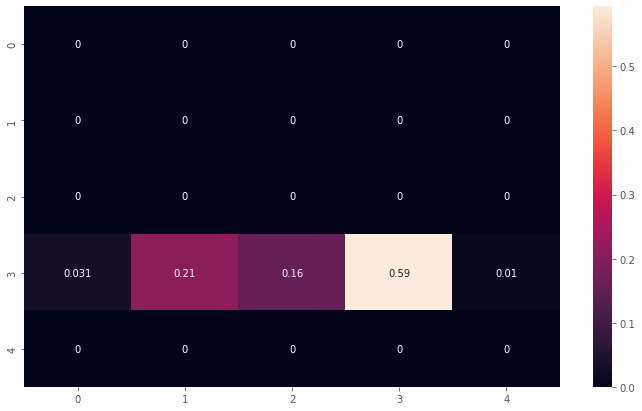

In [ ]:
import seaborn as sn
classes = ('anger', 'joy', 'neutral', 'surprise', 'disgust',
        'saddness', 'fear')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print (cf_matrix)
#df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) , index = [i for i in classes],
                    # columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix/(i+1), annot=True)

In [ ]:
plot_df.head()

,anger_c,joy_c,neutral_c,surprise_c,disgust_c,sadness_c,fear_c
0,0.006383,0.204528,0.195062,0.468632,4.342814e-03,0.120996,0.000055
0,0.970767,0.000470,0.020054,0.005844,8.787884e-08,0.000793,0.002071
0,0.006426,0.241250,0.189336,0.420876,4.443344e-03,0.137610,0.000059
0,0.726506,0.000704,0.236166,0.003958,7.725712e-07,0.013253,0.019412
0,0.006878,0.245658,0.187090,0.414628,4.528340e-03,0.141163,0.000055


In [ ]:
plot_df = plot_df.reset_index()

In [ ]:
plot_df = plot_df.drop("index",axis=1)
plot_df.head()

,anger_c,joy_c,neutral_c,surprise_c,disgust_c,sadness_c,fear_c
0,0.006383,0.204528,0.195062,0.468632,4.342814e-03,0.120996,0.000055
1,0.970767,0.000470,0.020054,0.005844,8.787884e-08,0.000793,0.002071
2,0.006426,0.241250,0.189336,0.420876,4.443344e-03,0.137610,0.000059
3,0.726506,0.000704,0.236166,0.003958,7.725712e-07,0.013253,0.019412
4,0.006878,0.245658,0.187090,0.414628,4.528340e-03,0.141163,0.000055


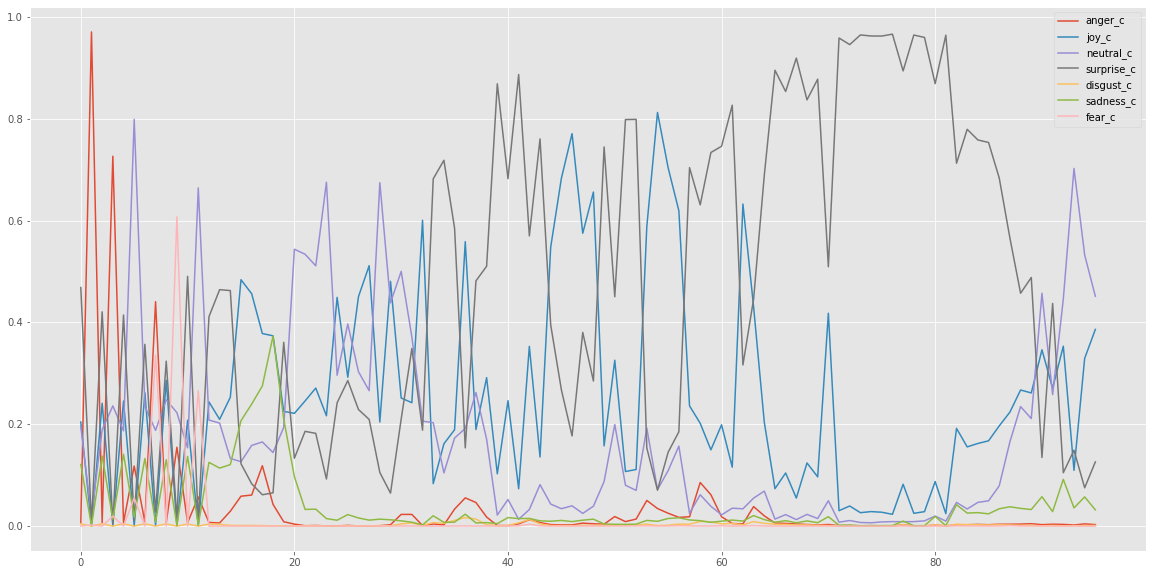

In [ ]:
plot_df.plot(figsize=(20, 10))

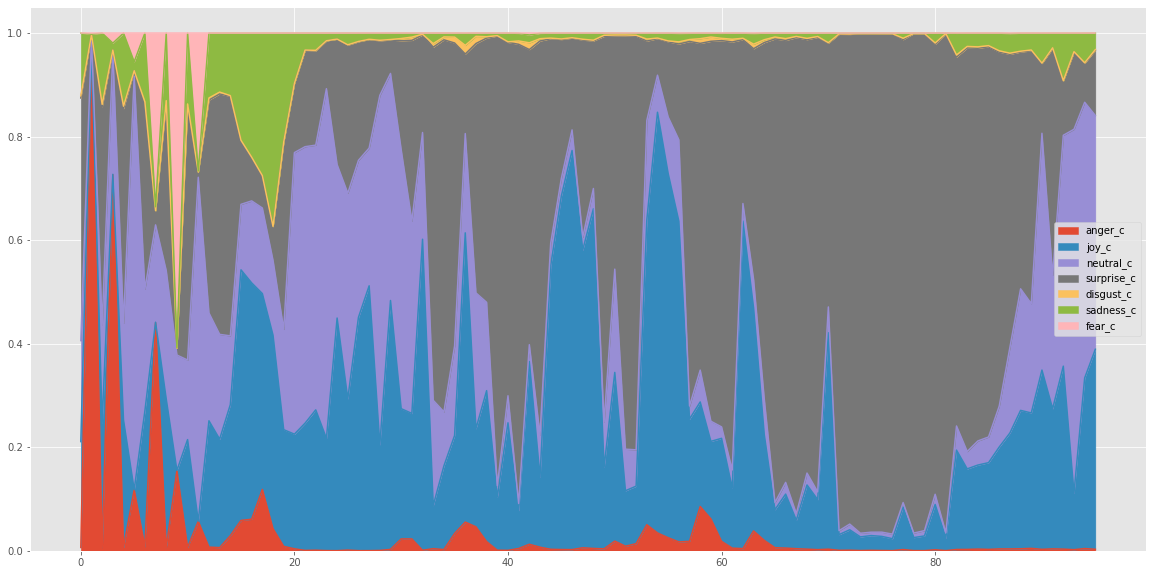

In [ ]:
plot_df.plot(kind='area',figsize=(20, 10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6aef66a90>,
      dtype=object)

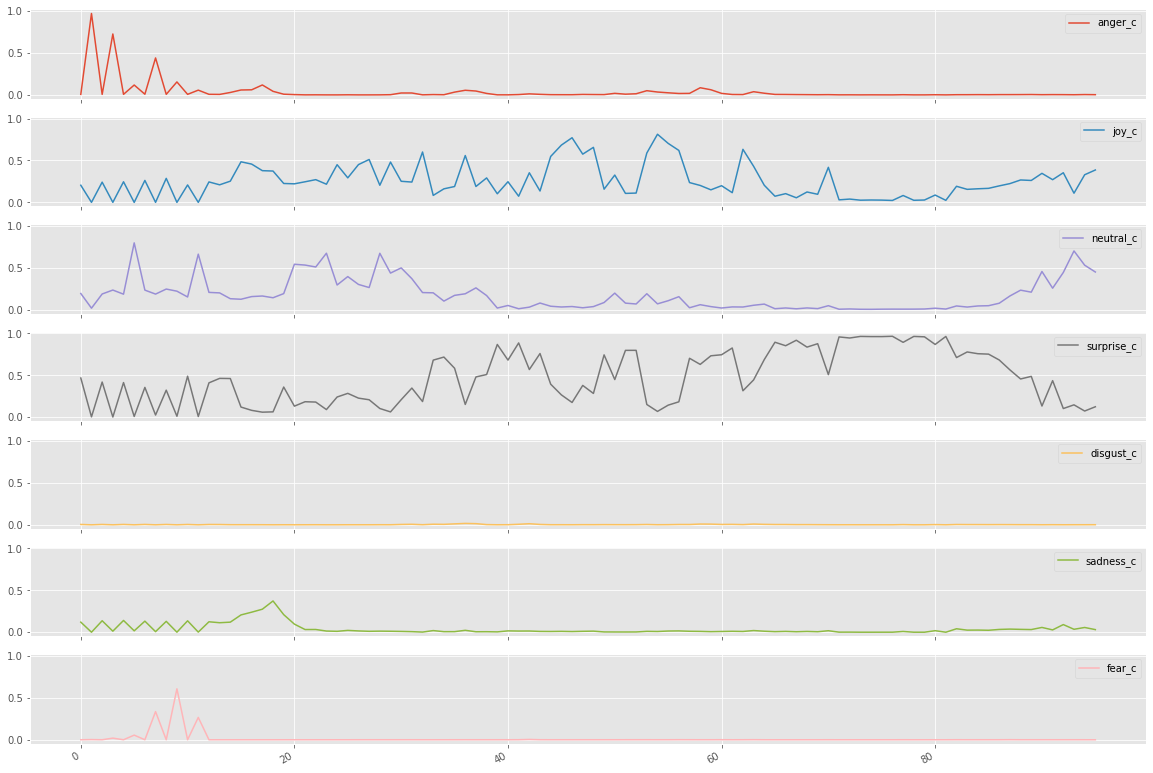

In [ ]:
plot_df.plot(subplots=True, sharey=True,figsize=(20, 15))